In [6]:
import sys
from supar import Parser

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [8]:
section = sys.argv[1]

In [9]:
with open('conll05.{}.plain'.format(section)) as f:
    lines = f.readlines()
    sents = [line.strip().split(' ') for line in lines]
#

In [10]:
with open('conll05.{}.heads'.format(section)) as f:
	lines = f.readlines()
	sents_heads = [line.strip().split(' ') for line in lines]
	sents_heads = [[int(head) for head in sent] for sent in sents_heads]

In [11]:
def one_hot(head):
	# print(head)
	b = np.zeros((head.size+1, head.size+1))
	b[np.arange(head.size)+1, head] = 1
	# print(b.shape)
	return b

In [12]:
parser_biaffine = Parser.load('biaffine-dep-en')
# parser_biaffine_bert = Parser.load('biaffine-dep-bert-en')
parser_crfnp_dep_en = Parser.load('crfnp-dep-en')
parser_crf2o_dep_en = Parser.load('crf2o-dep-en')

In [27]:
sents = ['I know who the count insulted yesterday .', 'I know who the count insulted the hostess yesterday .', 'I know that the count insulted yesterday .']
sents = [ _.split(' ') for _ in sents]

In [28]:
dataset_biaffine = parser_biaffine.predict(sents, prob=True, verbose=False)
# dataset_biaffine_bert = parser_biaffine_bert.predict(sents, prob=True, verbose=False)
dataset_crf2o_dep_en = parser_crf2o_dep_en.predict(sents, prob=True, verbose=False)
dataset_crfnp_dep_en = parser_crfnp_dep_en.predict(sents, prob=True, verbose=False)

100%|####################################| 2/2 00:00<00:00, 14.09it/s
100%|####################################| 2/2 00:00<00:00, 10.41it/s
100%|####################################| 2/2 00:00<00:00, 13.57it/s


In [29]:
attn_biaffine = [one_hot(np.array(arc)) for arc in dataset_biaffine.arcs]
# attn_biaffine_bert = [one_hot(np.array(arc)) for arc in dataset_biaffine_bert.arcs]
attn_crf2o_dep_en = [one_hot(np.array(arc)) for arc in dataset_crf2o_dep_en.arcs]
attn_crfnp_dep_en = [one_hot(np.array(arc)) for arc in dataset_crfnp_dep_en.arcs]
# attn_gold = [one_hot(np.array(arc)) for arc in sents_heads]

In [30]:
# a = np.random.random((16, 16))
# plt.imshow(a, cmap='hot', interpolation='nearest')
# plt.show()

In [31]:
# dataset = [(np.array(biaf)+np.array(crf2o)+np.array(crfnp))/3 for biaf, crf2o, crfnp in zip(dataset_biaffine.arcs, dataset_crf2o_dep_en.arcs, dataset_crfnp_dep_en.arcs)]

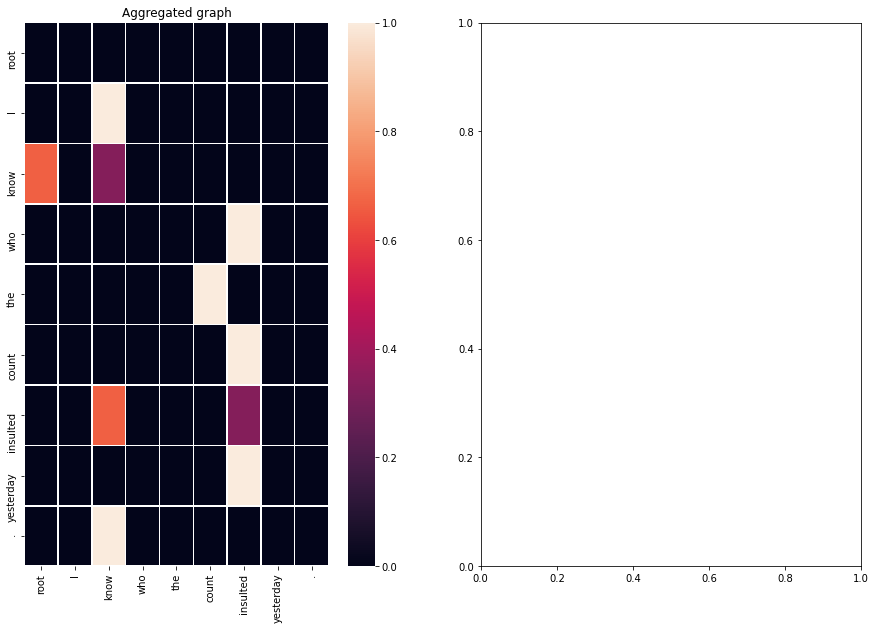

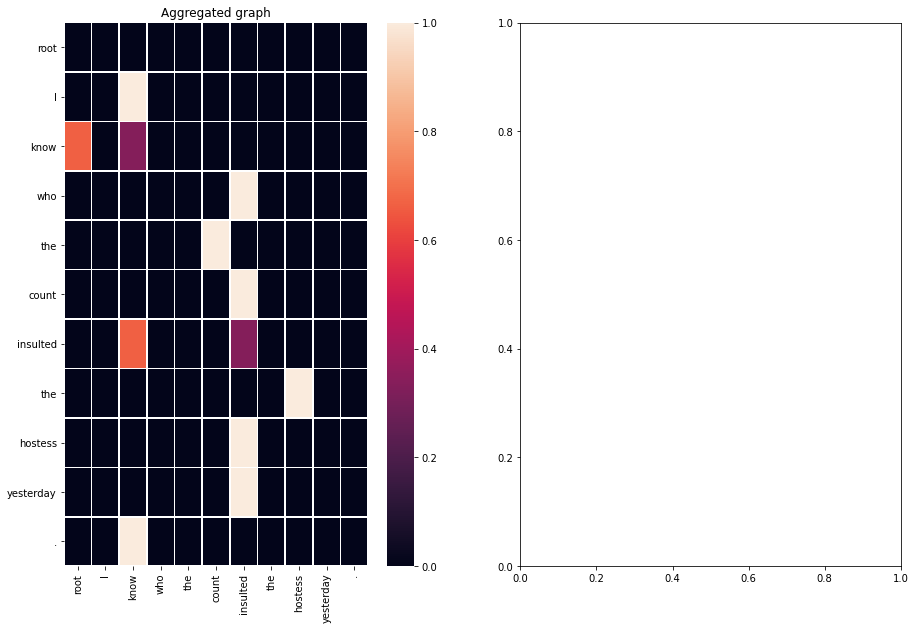

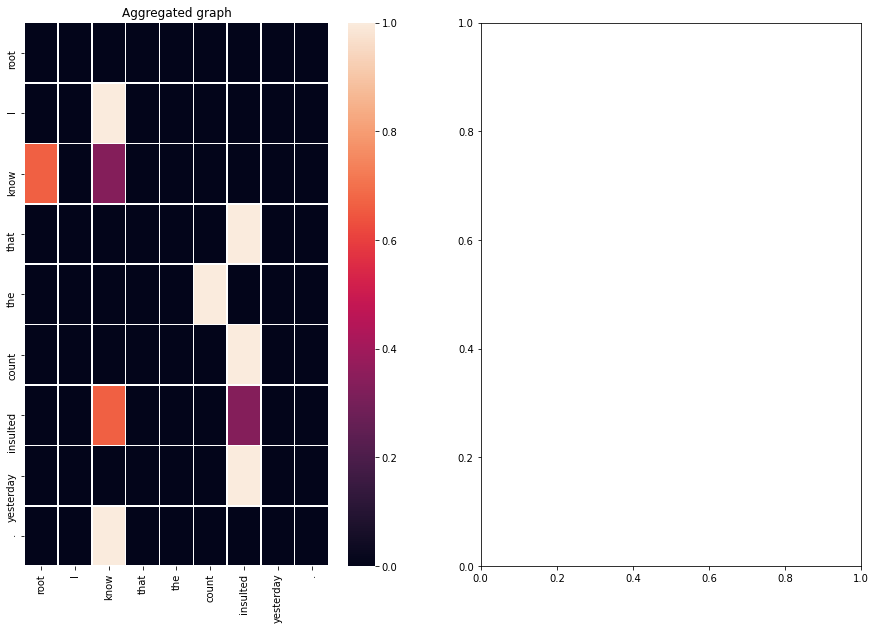

In [32]:
aggregated_heatmap_loss = 0.
for arc_biaf, arc_crf2o, arc_crfnp, sent, i in zip(attn_biaffine, attn_crf2o_dep_en, attn_crfnp_dep_en, sents, range(len(sents))):
	# print(arc_biaf_bert)
	# print(np.array(arc_biaf).shape, np.array(arc_biaf_bert).shape, np.array(arc_crf2o).shape, np.array(arc_crfnp).shape)
	# print(one_hot(np.array(arc_biaf)).shape, one_hot(np.array(arc_crf2o)).shape, one_hot(np.array(arc_crfnp)).shape)
	# heatmap = (one_hot(np.array(arc_biaf)) + one_hot(np.array(arc_biaf_bert)) +one_hot(np.array(arc_crf2o))+one_hot(np.array(arc_crfnp)))/4
	heatmap = (arc_biaf  + arc_crf2o + arc_crfnp)/3
	# print(heatmap)
	f, axes = plt.subplots(1, 2, figsize=(15, 10))
	axes[0].set_title('Aggregated graph')
	# axes[1].set_title('Gold graph')
	# print(head)
	sns.heatmap(heatmap, linewidth=0.5, xticklabels=['root']+sent, yticklabels=['root']+sent, ax=axes[0])
	# sns.heatmap(head, linewidth=0.5, xticklabels=['root']+sent, yticklabels=['root']+sent, ax=axes[1])

	# plt.savefig("integrated_heatmap/{}_sent{}.jpeg".format(section, i+1))
	# ax.plot()
	plt.show()
	# f.close()
	# aggregated_heatmap_loss += np.sum(np.linalg.norm(heatmap-head, axis=-1))
	# break

In [ ]:
for name, ind_parser in (("biaffine", attn_biaffine),
				   # ("biaffine_bert", attn_biaffine_bert),
				   ("crf_2o", attn_crf2o_dep_en),
				   ("crf_np", attn_crfnp_dep_en)):
	heatmap_loss = 0.
	for arc, sent, i in zip(ind_parser, sents, range(len(sents))):
		heatmap = arc#(arc_biaf + arc_biaf_bert + arc_crf2o + arc_crfnp)/4
		f, axes = plt.subplots(1, 2, figsize=(30, 20))
		axes[0].set_title('biaffine graph')
		axes[1].set_title('Gold graph')
		sns.heatmap(heatmap, linewidth=0.5, xticklabels=['root']+sent, yticklabels=['root']+sent, ax=axes[0])
		# sns.heatmap(head, linewidth=0.5, xticklabels=['root']+sent, yticklabels=['root']+sent, ax=axes[1])
		plt.show()
		# plt.savefig("{}_heatmap/{}_sent{}.jpeg".format(name, section, i+1))
		heatmap_loss += np.sum(np.linalg.norm(heatmap-head, axis=-1))
		# break
	print("{} loss: {}".format(name, heatmap_loss/len(sents_heads)))

In [ ]:
# print("biaf loss: {}".format(biaf_heatmap_loss/len(sents_heads)))
print("aggregated loss: {}".format(aggregated_heatmap_loss/len(sents_heads)))